In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,sklearn,pandas
%watermark -v -p cv2,PIL,matplotlib
%watermark -v -p torch,torchvision,torchaudio,pytorch_lightning
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

from IPython.display import display, HTML, Javascript
display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

def _IMPORT_(x):
    try:
        exec(x, globals())
    except:
        pass


CPython 3.6.9
IPython 7.16.1

numpy 1.18.5
sklearn 0.24.0
pandas 1.1.5
CPython 3.6.9
IPython 7.16.1

cv2 4.5.1
PIL 6.2.2
matplotlib 3.3.3
CPython 3.6.9
IPython 7.16.1

torch 1.8.0.dev20210103+cu101
torchvision 0.9.0.dev20210103+cu101
torchaudio not installed
pytorch_lightning 1.2.0


In [2]:
###
### Common ###
###

import sys, os, io, time, random, math
import json, base64, requests

import os.path as osp

_IMPORT_('import numpy as np')
_IMPORT_('import pandas as pd')
_IMPORT_('from tqdm.notebook import tqdm')

def print_progress_bar(x):
    print('\r', end='')
    print('Progress: {}%:'.format(x), '%s%s' % ('▋'*(x//2), '.'*((100-x)//2)), end='')
    sys.stdout.flush()

###
### Torch ###
###

_IMPORT_('import torch')
_IMPORT_('import torch.nn as nn')
_IMPORT_('import torch.nn.functional as F')
_IMPORT_('import torch.optim as O')
_IMPORT_('from torchvision import models as M')
_IMPORT_('from torchvision import transforms as T')
_IMPORT_('from torch.utils.data import Dataset, DataLoader')

###
### Display ###
###

_IMPORT_('import cv2')
_IMPORT_('from PIL import Image')
_IMPORT_('from torchvision.utils import make_grid')
_IMPORT_('import matplotlib.pyplot as plt')
_IMPORT_('import plotly')
_IMPORT_('import plotly.graph_objects as go')

# plotly.offline.init_notebook_mode(connected=False)

def show_video(video_path, width=None, height=None):
    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if video_path.startswith('http'):
        data_url = video_path
    else:
        mp4 = open(video_path, 'rb').read()
        data_url = 'data:video/mp4;base64,' + base64.b64encode(mp4).decode()
    return HTML('<video %s %s controls src="%s" type="video/mp4"/>' % (W, H, data_url))

def show_image(image_path, width=None, height=None):
    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if image_path.startswith('http'):
        data_url = image_path
    else:
        img = open(image_path, 'rb').read()
        data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<img %s %s src="%s"/>' % (W, H, data_url))

In [3]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from random import randrange, randint
import matplotlib.animation as animation
import glob

In [4]:
DATASET_ROOT = '/data/datasets/cv/repnet_datasets'

In [5]:
class CountixSynthDataset(Dataset):
    def __init__(self, data_root, phase, frame_size=112, num_frames=64):
        self.data_root = data_root
        self.num_frames = num_frames
        self.frame_size = (frame_size, frame_size) if isinstance(frame_size, int) else frame_size
        self.data = self._make_valid_data(data_root, phase)
        
    def _make_valid_data(self, data_root, phase):
        synthvids_paths = glob.glob(f'{data_root}/synthvids/*.mp4')
        data = []
        df_all = pd.read_csv(f'{data_root}/countix/countix_{phase}.csv')
        valid_index = []
        valid_paths = []
        for i in range(len(df_all)):
            vpath = f'{data_root}/{phase}vids/{phase}{i}.mp4'
            if osp.exists(vpath):
                valid_index.append(i)
                valid_paths.append(vpath)
        df_valid = df_all.iloc[valid_index]
        valid_counts = df_valid['count']
        random_synth = random.choices(synthvids_paths, k=len(valid_paths))
        return list(zip(valid_paths, valid_counts, random_synth))
    
    def _get_frames(self, path):
        frames = []
        if path is None:
            path = self.path
        
        cap = cv2.VideoCapture(path)
        while cap.isOpened():
            ret, frame = cap.read()
            if ret is False:
                break
            img = Image.fromarray(frame)
            frames.append(img)
        
        cap.release()
        assert len(frames) > 0, path
        return frames
    
    def _skip_frames(self, frames, count):
        new_frames = []
        l = len(frames)
        for i in range(1, count + 1):
            new_frames.append(frames[i * l // count - 1])
        return new_frames

    def __getitem__(self, index):
        cvid_path, cvid_count, svid_path = self.data[index]
        cframes = self._get_frames(cvid_path)
        sframes = self._get_frames(svid_path)
        
        cvid_len = min(len(cframes), randint(int(0.7 * self.num_frames), self.num_frames))
        head_len = randint(0, self.num_frames - cvid_len)
        tail_len = self.num_frames - cvid_len - head_len
        
        cframes = self._skip_frames(cframes, cvid_len)
        sframes = self._skip_frames(sframes, head_len + tail_len)

        same = np.random.choice([0, 1], p = [0.5, 0.5])
        if same:
            final_frames = [cframes[0] for i in range(head_len)]
            final_frames.extend(cframes)        
            final_frames.extend([cframes[-1] for i in range(tail_len)] )
        else:
            final_frames = sframes[:head_len]
            final_frames.extend(cframes)
            final_frames.extend(sframes[head_len:])      
            
        # TODO DEBUG
        if index == 0:
            self.final_frames = final_frames
        
        Xlist = []
        for img in final_frames:
            preprocess = T.Compose([
                T.Resize(self.frame_size),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
            Xlist.append(preprocess(img).unsqueeze(0))
        
        p_len = cvid_len / cvid_count
        p_len = p_len if 1 < p_len < int(self.num_frames / 2) else 0
        
        y1 = np.full((self.num_frames, 1), fill_value=p_len)
        y2 = np.ones((self.num_frames, 1)) 
        
        for i in range(self.num_frames):
            if i < head_len or i > (self.num_frames - tail_len):
                y1[i] = 0
                y2[i] = 0
                Xlist[i] = F.dropout(Xlist[i], 0.2)
                
        X = torch.cat(Xlist)
        y1 = torch.FloatTensor(y1)
        y2 = torch.FloatTensor(y2)
        y3 = torch.FloatTensor([cvid_count])
        
        return X, y1, y2, y3

    def __len__(self):
        return len(self.data)

In [6]:
test_dataset = CountixSynthDataset(DATASET_ROOT, 'test')
X, y1, y2, y3 = next(iter(test_dataset))

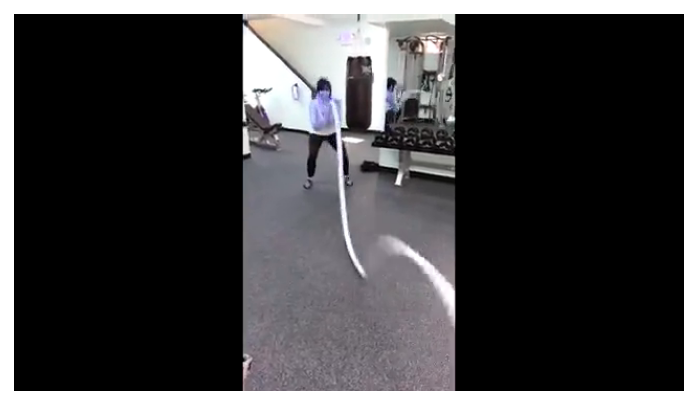

In [23]:
fig = plt.figure()
plt.axis('off')
frames = []
for img in test_dataset.final_frames:
    frames.append([plt.imshow(img)])
anim = animation.ArtistAnimation(
    fig, frames, interval=50, blit=True,
    repeat_delay=1000)
HTML(anim.to_html5_video())